# This notebook will look at how features in different neighborhoods affect SalePrice

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import shap


# import seaborn as sns
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import cross_val_score, KFold


# the below extension properly formats a cell after it is run
%load_ext nb_black

# Set the maximum number of rows to 200
pd.set_option("display.max_rows", 200)


# Set the maximum number of columns to 200
pd.set_option("display.max_columns", 200)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [31]:
# Load Data
housing = pd.read_csv("../data/housing_corr.csv")

<IPython.core.display.Javascript object>

In [32]:
# Dropping columns not needed
housing.drop(
    ["PID", "Neighborhood_st"], axis=1, inplace=True,
)

<IPython.core.display.Javascript object>

## Ordinal encoding data

In [33]:
# get a list of categorical features (i.e., object type columns)
cat_features = list(housing.select_dtypes(include=["object"]).columns)

# Keeping Neighborhood
# cat_features.remove("Neighborhood")

# create an instance of the OrdinalEncoder class
ordinal_encoder = OrdinalEncoder()


# fit the ordinal encoder to the categorical features
ordinal_encoder.fit(housing[cat_features])

# transform the categorical features into encoded numerical values
housing[cat_features] = ordinal_encoder.transform(housing[cat_features])

<IPython.core.display.Javascript object>

## Getting the top 25 most important features

In [34]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    housing.drop(["SalePrice"], axis=1),
    housing["SalePrice"],
    test_size=0.2,
    random_state=42,
)

# Train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Calculate feature importances
feature_importances = rf.feature_importances_

# Get the top 25 features
top_25_features = (
    pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importances})
    .sort_values("Importance", ascending=False)
    .head(25)
)

print("Top 25 features:")
print(top_25_features)

# Create a new DataFrame with only the top 25 features
housing_top_25 = housing[top_25_features["Feature"].tolist() + ["SalePrice"]]

Top 25 features:
           Feature  Importance
15     OverallQual    0.490997
56         TotalSF    0.315978
54             Age    0.021333
40     KitchenQual    0.015772
2          LotArea    0.013003
58       TotalBath    0.012872
55        RemodAge    0.012398
30       BsmtUnfSF    0.010997
28      BsmtFinSF1    0.010385
22      MasVnrArea    0.010251
61  TotalOutdoorSF    0.007366
16     OverallCond    0.006818
46      GarageCars    0.005880
43      Fireplaces    0.005694
1      LotFrontage    0.004868
25        BsmtQual    0.004636
10    Neighborhood    0.003880
50          MoSold    0.003545
0         MSZoning    0.003086
59  MSSubClass_cat    0.002449
41    TotRmsAbvGrd    0.002317
20     Exterior2nd    0.002053
60     Street_type    0.001949
19     Exterior1st    0.001847
45    GarageFinish    0.001834


<IPython.core.display.Javascript object>

# Creating new Dataframe with only the top features

In [43]:
# Load Data
housing = pd.read_csv("../data/housing_corr.csv")

# Dropping columns not needed
housing.drop(
    ["PID", "Neighborhood_st"], axis=1, inplace=True,
)

# get a list of categorical features (i.e., object type columns)
cat_features = list(housing.select_dtypes(include=["object"]).columns)

# Keeping Neighborhood
cat_features.remove("Neighborhood")

# create an instance of the OrdinalEncoder class
ordinal_encoder = OrdinalEncoder()


# fit the ordinal encoder to the categorical features
ordinal_encoder.fit(housing[cat_features])

# transform the categorical features into encoded numerical values
housing[cat_features] = ordinal_encoder.transform(housing[cat_features])

<IPython.core.display.Javascript object>

In [44]:
# Keep only the top 25 features, 'SalePrice', and 'Neighborhood' in the housing DataFrame
selected_columns = top_25_features["Feature"].tolist() + ["SalePrice"]
housing = housing[selected_columns]


<IPython.core.display.Javascript object>

In [ ]:
## Looking at how Shap values differ in each neighborhood

In [46]:
"""
This script performs the following tasks:

1. Trains a Random Forest Regressor for each 'Neighborhood' to predict 'SalePrice'.
2. Extracts and prints the top 6 important features for each 'Neighborhood'.
3. Calculates and prints the mean absolute SHAP values for the top 6 important features in each 'Neighborhood'.
"""

# Get unique neighborhoods
unique_neighborhoods = housing['Neighborhood'].unique()

shap_values_dict = {}

# Loop through each neighborhood
for neighborhood in unique_neighborhoods:
    print(f"Analyzing neighborhood: {neighborhood}")

    # Filter data based on the neighborhood
    neighborhood_data = housing[housing['Neighborhood'] == neighborhood]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(neighborhood_data.drop(["SalePrice", "Neighborhood"], axis=1),
                                                        neighborhood_data["SalePrice"], test_size=0.2, random_state=42, )

    # Train the Random Forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Calculate feature importances
    feature_importances = rf.feature_importances_

    # Analyze the feature importances
    important_features = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances}).sort_values('Importance', ascending=False).head(6)

    print(important_features)

    # Calculate SHAP values for the top 6 features
    explainer = shap.Explainer(rf, X_train)
    shap_values = explainer(X_test)

    # Get the SHAP values for the top 6 features
    top_feature_indices = [X_train.columns.get_loc(col) for col in important_features["Feature"].tolist()]  # Get column indices
    top_feature_shap_values = shap_values[:, top_feature_indices]

    # Calculate the mean absolute SHAP values for each feature
    mean_abs_shap_values = np.abs(top_feature_shap_values.values).mean(axis=0)  # Extract the values from the Explanation object

    # Print the SHAP values
    print("Mean absolute SHAP values:")
    for feature, value in zip(important_features["Feature"], mean_abs_shap_values):
        print(f"{feature}: {value}")

    print("\n")

    # Store the SHAP values in the dictionary for later use
    shap_values_dict[neighborhood] = shap_values




Analyzing neighborhood: SWISU
         Feature  Importance
1        TotalSF    0.165503
19  TotRmsAbvGrd    0.139510
11   OverallCond    0.129823
6       RemodAge    0.091817
4        LotArea    0.090908
5      TotalBath    0.062473
Mean absolute SHAP values:
TotalSF: 2702.1334947480095
TotRmsAbvGrd: 4373.44549645318
OverallCond: 4871.109800842073
RemodAge: 3969.360387023952
LotArea: 3433.8463066617646
TotalBath: 1605.2657951878177


Analyzing neighborhood: Edwards
       Feature  Importance
1      TotalSF    0.424324
4      LotArea    0.158304
2          Age    0.072688
6     RemodAge    0.047341
7    BsmtUnfSF    0.030712
13  Fireplaces    0.024910
Mean absolute SHAP values:
TotalSF: 18952.962739894792
LotArea: 6623.757285540049
Age: 4083.8390098242326
RemodAge: 3519.891207986077
BsmtUnfSF: 794.6834566368659
Fireplaces: 964.721779620539


Analyzing neighborhood: IDOTRR
        Feature  Importance
1       TotalSF    0.420943
0   OverallQual    0.226020
6      RemodAge    0.096546
11  

           Feature  Importance
8       BsmtFinSF1    0.438871
10  TotalOutdoorSF    0.104256
4          LotArea    0.080174
16          MoSold    0.066915
13      Fireplaces    0.063973
20     Exterior2nd    0.062068
Mean absolute SHAP values:
BsmtFinSF1: 8255.48641459147
TotalOutdoorSF: 1431.3021596272788
LotArea: 683.2987162272135
MoSold: 177.77782185872394
Fireplaces: 1323.8716430664062
Exterior2nd: 419.0972137451172


Analyzing neighborhood: ClearCr
       Feature  Importance
4      LotArea    0.276717
0  OverallQual    0.144902
8   BsmtFinSF1    0.121348
1      TotalSF    0.114357
6     RemodAge    0.096615
2          Age    0.024776
Mean absolute SHAP values:
LotArea: 16703.185776410566
OverallQual: 5952.211620053938
BsmtFinSF1: 5127.341039934467
TotalSF: 7021.510578724647
RemodAge: 5575.418382906145
Age: 1282.3068737291524


Analyzing neighborhood: StoneBr
           Feature  Importance
9       MasVnrArea    0.302395
1          TotalSF    0.281602
4          LotArea    0.142779


<IPython.core.display.Javascript object>

In [58]:
housing["Neighborhood"].value_counts()

NAmes      408
CollgCr    236
OldTown    208
Edwards    163
Somerst    143
Gilbert    143
Sawyer     139
NWAmes     123
NridgHt    121
SawyerW    112
Mitchel    103
BrkSide    103
Crawfor     92
IDOTRR      73
NoRidge     67
Timber      52
StoneBr     43
SWISU       41
ClearCr     39
MeadowV     34
BrDale      29
Blmngtn     23
Veenker     23
NPkVill     22
Blueste     10
Greens       8
Name: Neighborhood, dtype: int64

<IPython.core.display.Javascript object>

Plotting SHAP values for neighborhood: SWISU


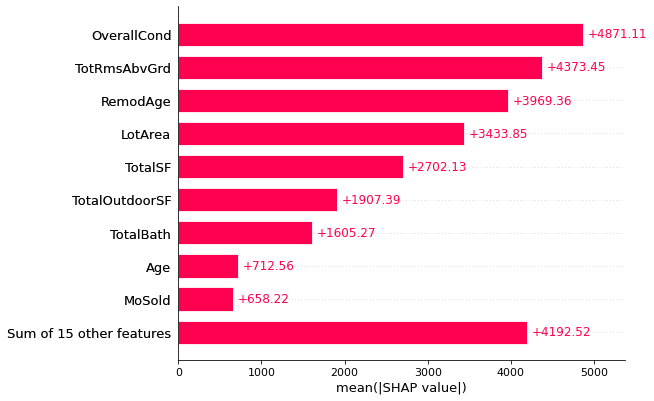

Plotting SHAP values for neighborhood: Edwards


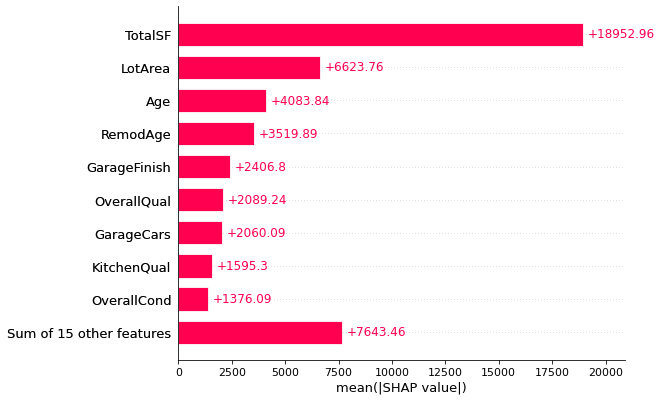

Plotting SHAP values for neighborhood: IDOTRR


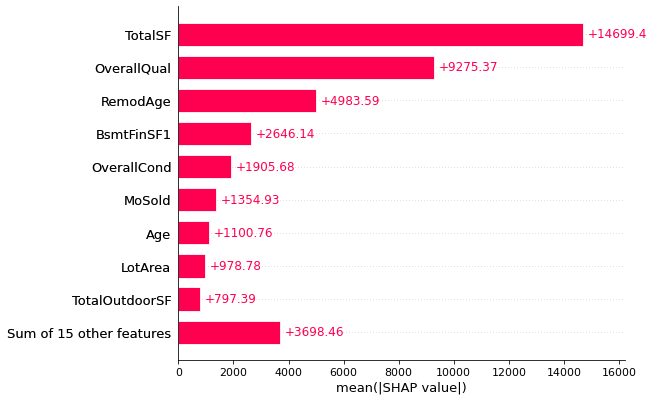

Plotting SHAP values for neighborhood: OldTown


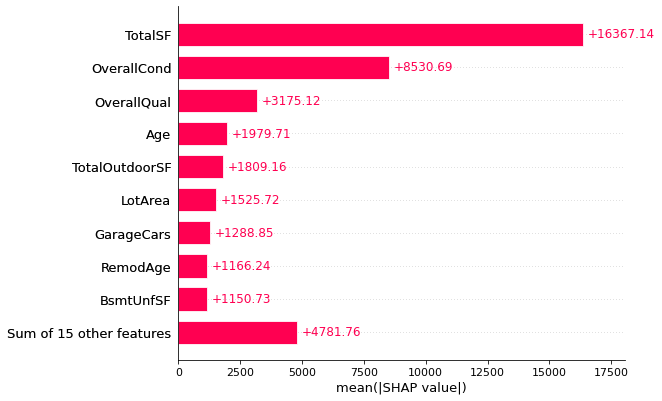

Plotting SHAP values for neighborhood: NWAmes


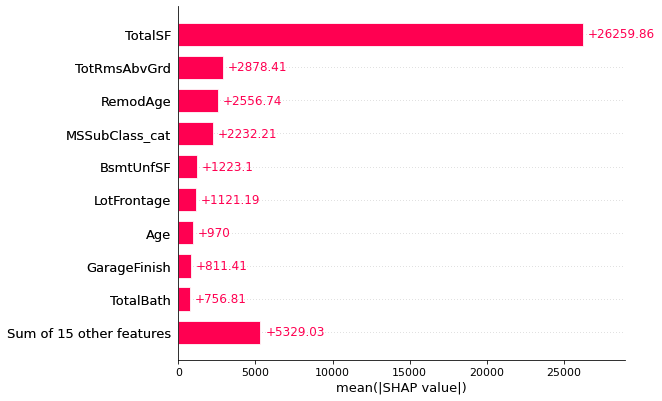

Plotting SHAP values for neighborhood: Blmngtn


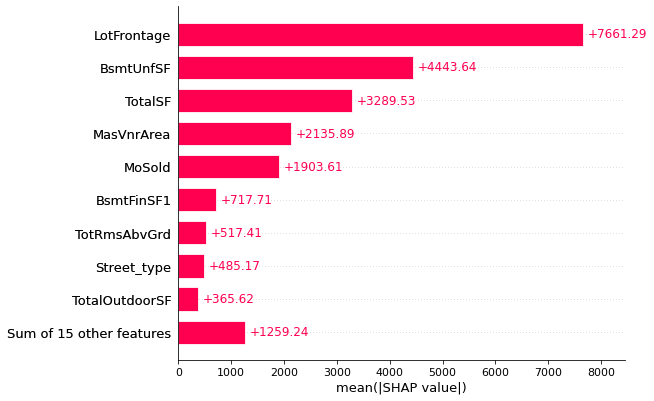

Plotting SHAP values for neighborhood: Mitchel


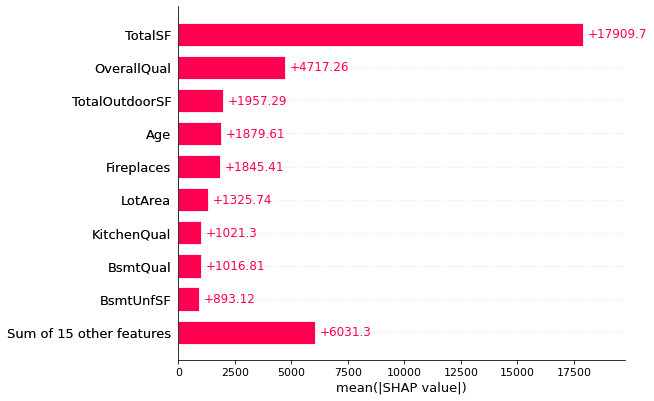

Plotting SHAP values for neighborhood: NridgHt


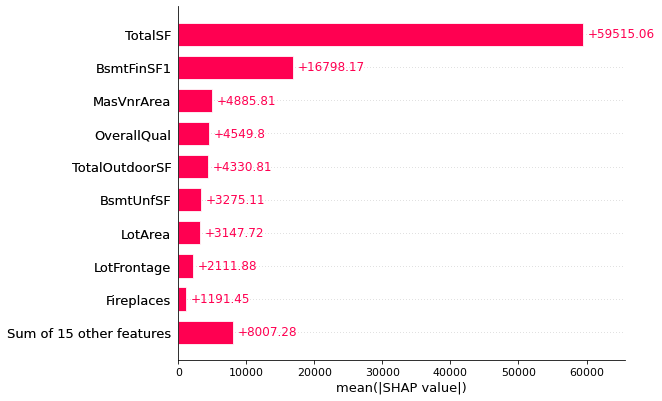

Plotting SHAP values for neighborhood: NAmes


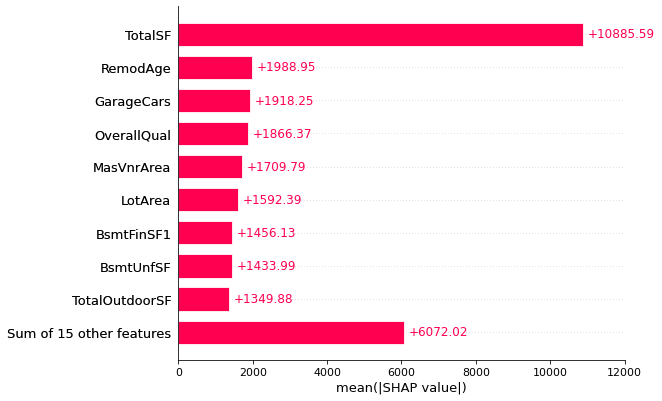

Plotting SHAP values for neighborhood: CollgCr


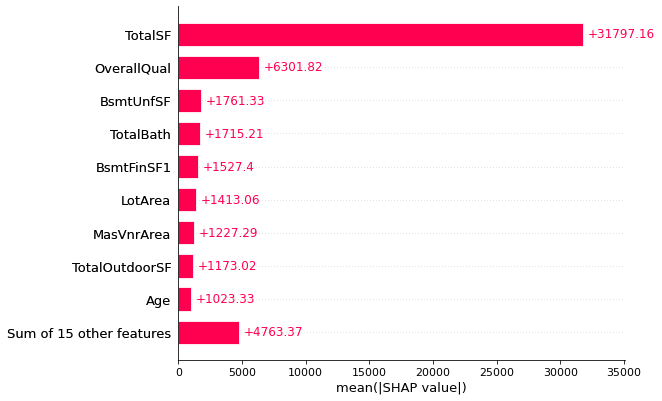

Plotting SHAP values for neighborhood: SawyerW


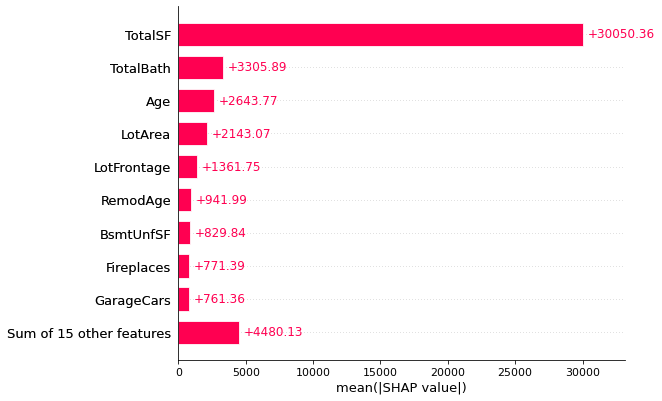

Plotting SHAP values for neighborhood: MeadowV


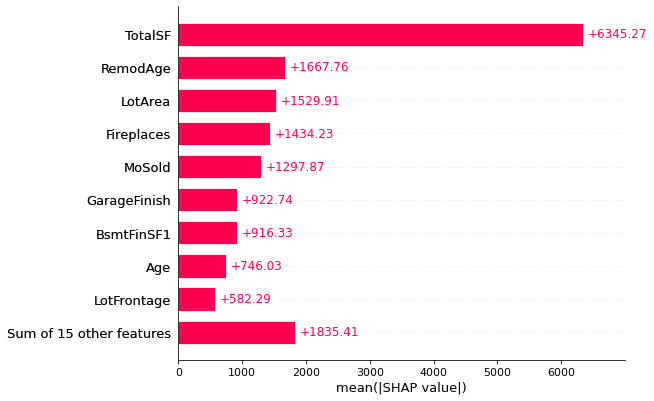

Plotting SHAP values for neighborhood: BrDale


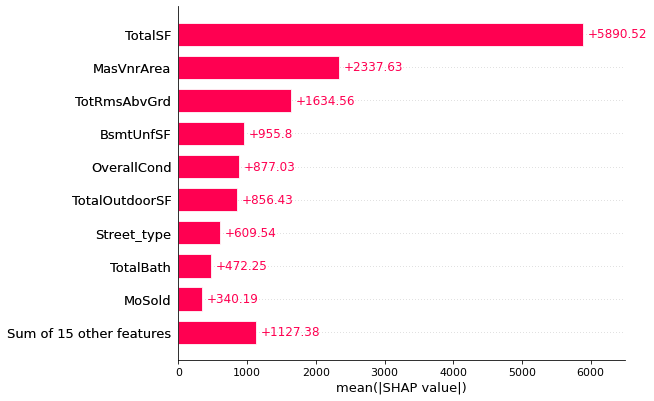

Plotting SHAP values for neighborhood: Gilbert


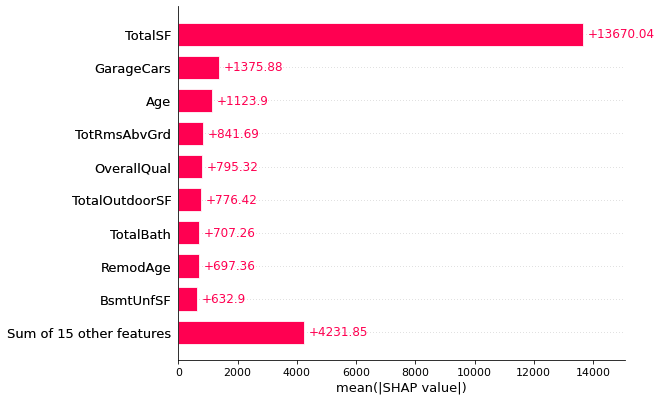

Plotting SHAP values for neighborhood: Timber


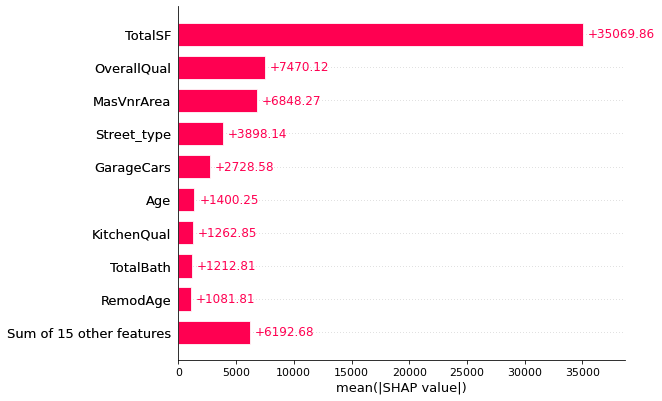

Plotting SHAP values for neighborhood: Somerst


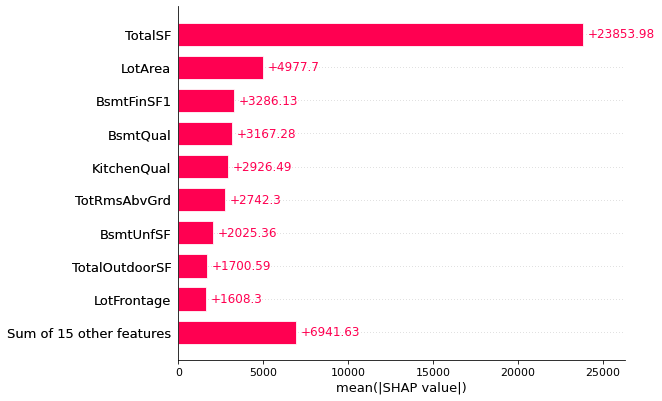

Plotting SHAP values for neighborhood: BrkSide


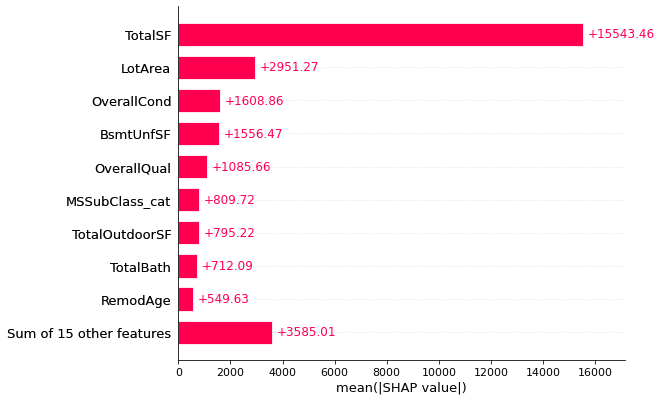

Plotting SHAP values for neighborhood: NoRidge


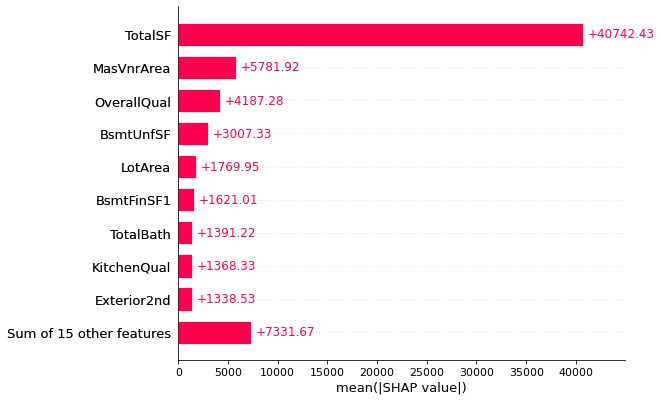

Plotting SHAP values for neighborhood: Sawyer


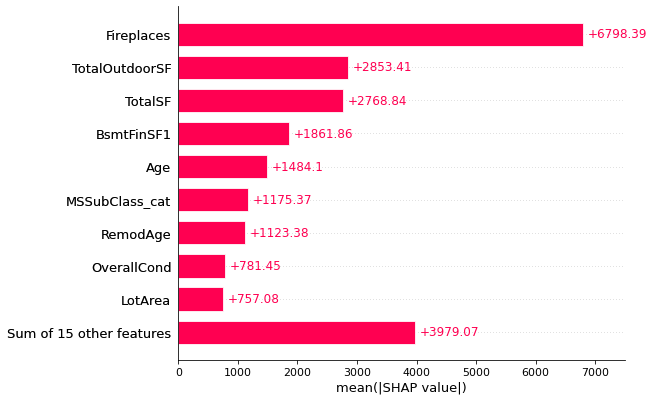

Plotting SHAP values for neighborhood: Crawfor


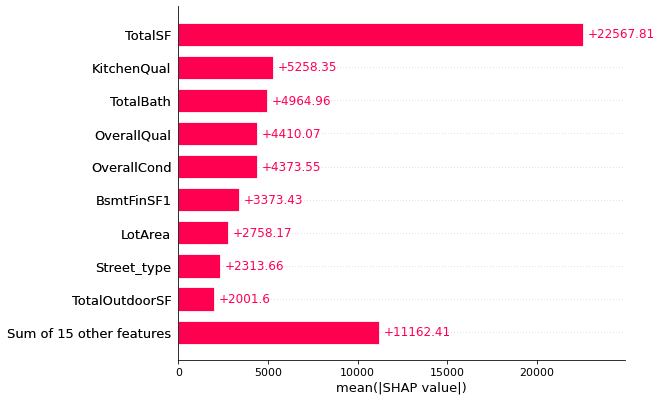

Plotting SHAP values for neighborhood: Greens


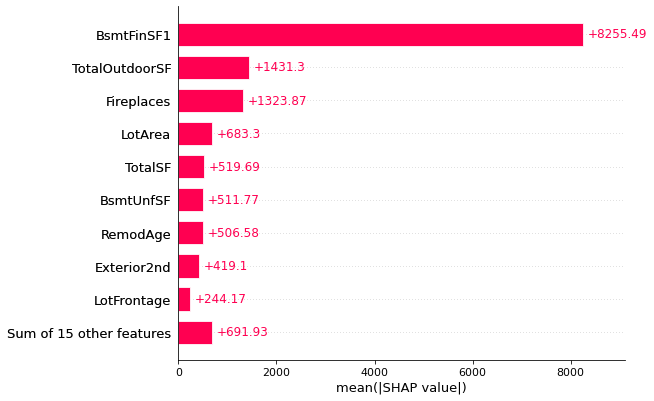

Plotting SHAP values for neighborhood: ClearCr


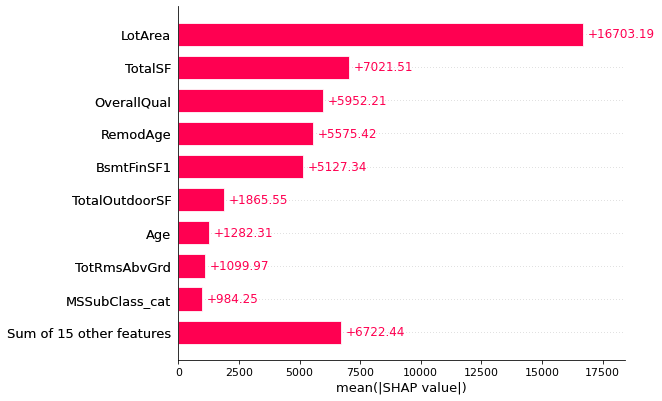

Plotting SHAP values for neighborhood: StoneBr


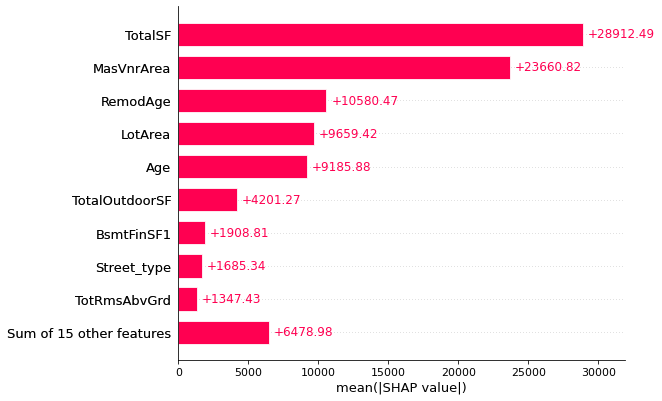

Plotting SHAP values for neighborhood: Veenker


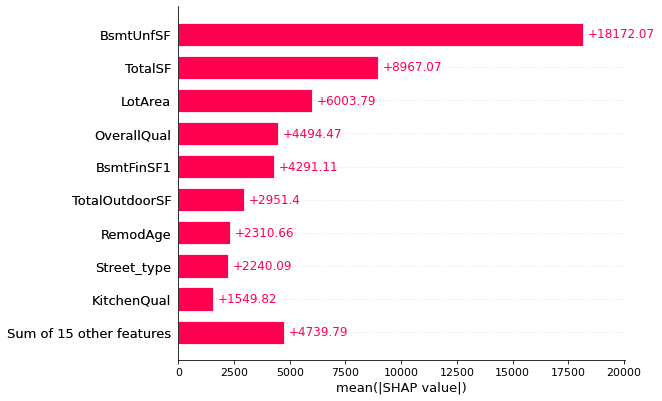

Plotting SHAP values for neighborhood: NPkVill


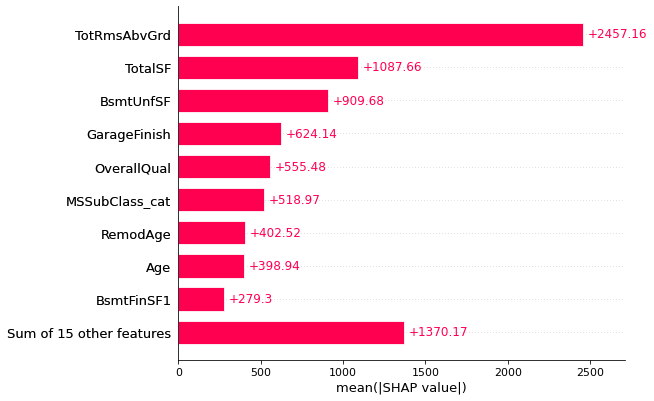

Plotting SHAP values for neighborhood: Blueste


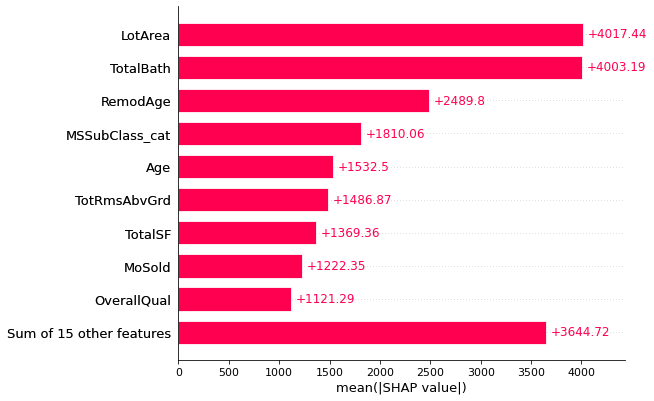

<IPython.core.display.Javascript object>

In [51]:
# Loop through each neighborhood
for neighborhood in unique_neighborhoods:
    print(f"Plotting SHAP values for neighborhood: {neighborhood}")
    
    # Get the SHAP values for the neighborhood
    shap_values_to_plot = shap_values_dict[neighborhood]

    # Plot the SHAP values
    shap.plots.bar(shap_values_to_plot)


# TotalBath is important in the Blueste Nighborhood so I will look at all the observations since there are only 10

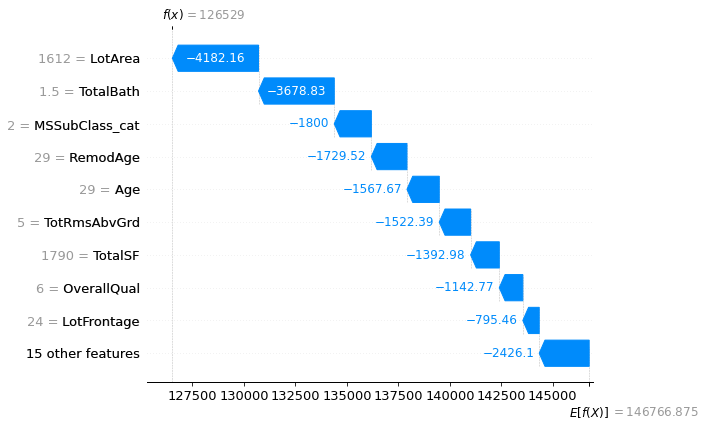

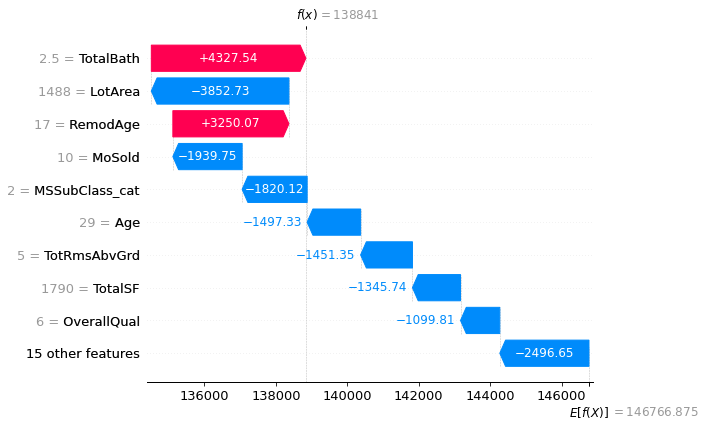

<IPython.core.display.Javascript object>

In [54]:
# Waterfall Plot: Visualizes the SHAP values for a SINGLE instance in a waterfall manner,
# showing the cumulative effect of each feature on the prediction.
shap_values_to_plot = shap_values_dict["Blueste"]
for instance_shap_values in shap_values_to_plot:
    shap.plots.waterfall(instance_shap_values)


# SHAP values are only for the test data which is why only two waterfalls appear when there is 10 observations before it was split into Train Test